<a href="https://colab.research.google.com/github/zzc029498-max/nec-/blob/main/part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data prepared: Training samples=400, Test samples=100
Training Custom BP Model...
Custom BP Training Complete.
Training Open-Source BP-F (MLPRegressor)...
Open-Source BP-F Training Complete.
Training Open-Source MLR-F (LinearRegression)...
Open-Source MLR-F Training Complete.

--- Model Comparison Metrics (on Scaled Test Data) ---
| Model                    |    MSE |    MAE |   MAPE (%) |
|:-------------------------|-------:|-------:|-----------:|
| Custom BP                | 0.0112 | 0.0855 |   187.5331 |
| BP-F (MLPRegressor)      | 0.0239 | 0.1177 |   103.6464 |
| MLR-F (LinearRegression) | 0.0028 | 0.0426 |    52.4215 |


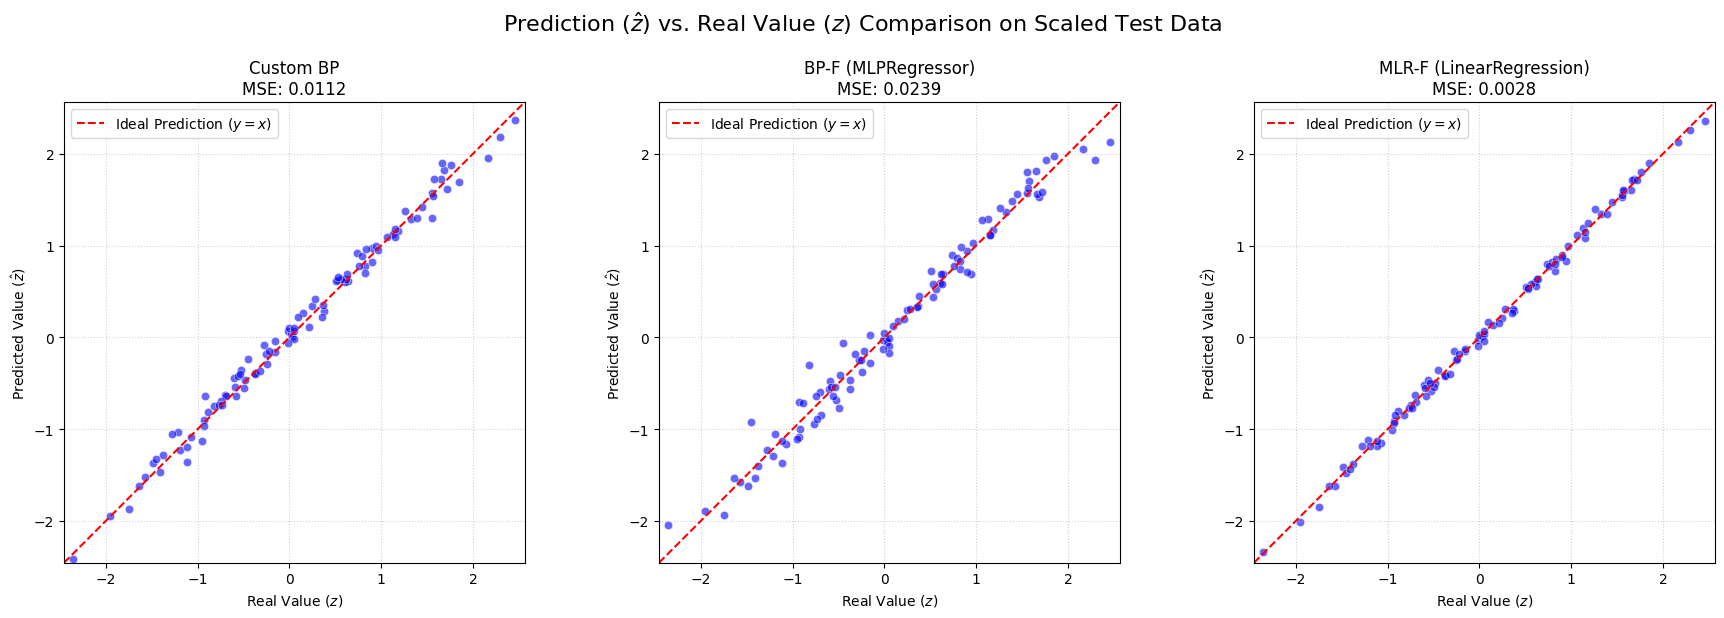

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression

class NeuralNet:
    """
    Implementation of a Back-Propagation (BP) Neural Network from scratch.
    """

    def __init__(self, network_architecture, n_epochs, learning_rate, momentum, activation_function, validation_split):
        self.n_epochs = n_epochs
        self.lr = learning_rate
        self.mu = momentum
        self.fact_name = activation_function
        self.validation_split = validation_split

        self.L = len(network_architecture)
        self.n = network_architecture.copy()

        self.xi = [None] * self.L
        self.h = [None] * self.L
        self.delta = [None] * self.L
        self.w = [None] * self.L
        self.theta = [None] * self.L
        self.dw = [None] * self.L
        self.dtheta = [None] * self.L
        self.d_w_prev = [None] * self.L
        self.d_theta_prev = [None] * self.L

        for l in range(self.L):
            n_units = self.n[l]
            self.xi[l] = np.zeros(n_units)
            self.h[l] = np.zeros(n_units)
            self.delta[l] = np.zeros(n_units)

            if l > 0:
                n_units_prev = self.n[l-1]

                self.theta[l] = np.zeros(n_units)
                self.dtheta[l] = np.zeros(n_units)
                self.d_theta_prev[l] = np.zeros(n_units)

                # He/Xavier Initialization
                if self.fact_name == 'relu':
                    limit = np.sqrt(2 / n_units_prev)
                    self.w[l] = np.random.normal(0, limit, (n_units, n_units_prev))
                else:
                    limit = np.sqrt(6 / (n_units_prev + n_units))
                    self.w[l] = np.random.uniform(-limit, limit, (n_units, n_units_prev))

                self.dw[l] = np.zeros((n_units, n_units_prev))
                self.d_w_prev[l] = np.zeros((n_units, n_units_prev))

        self.train_loss_history = []
        self.val_loss_history = []

    def fit(self, X, y):
        # Reset loss history before training
        self.train_loss_history = []
        self.val_loss_history = []

        # We only train on the full X, y here, validation is handled in 3.1
        X_train, y_train = X, y

        n_samples = X_train.shape[0]
        output_layer_index = self.L - 1

        for epoch in range(self.n_epochs):
            train_epoch_losses = []
            indices = np.random.permutation(n_samples)
            X_train_shuffled = X_train[indices]
            y_train_shuffled = y_train[indices]

            for i in range(n_samples):
                x_sample = X_train_shuffled[i]
                y_sample = y_train_shuffled[i]

                self._forward_pass(x_sample)

                prediction = self.xi[output_layer_index]
                train_epoch_losses.append(self._mse_loss(np.atleast_1d(y_sample), prediction))

                self._backward_pass(y_sample)
                self._update_weights()

            avg_train_loss = np.mean(train_epoch_losses)
            self.train_loss_history.append(avg_train_loss)

    def predict(self, X):
        predictions = []
        for x_sample in X:
            self._forward_pass(x_sample)
            predictions.append(self.xi[self.L - 1].copy())

        return np.array(predictions)

    def _forward_pass(self, x):
        output_layer_index = self.L - 1
        self.xi[0] = x

        for l in range(1, self.L):
            self.h[l] = self.w[l] @ self.xi[l-1] + self.theta[l]

            if l < output_layer_index:
                self.xi[l] = self._activation(self.h[l])
            else:
                self.xi[l] = self.h[l]

    def _backward_pass(self, y_true):
        y_true_arr = np.atleast_1d(y_true)
        output_layer_index = self.L - 1

        # 1. Output Layer Delta (Linear output)
        error_signal = y_true_arr - self.xi[output_layer_index]
        self.delta[output_layer_index] = error_signal * np.ones_like(self.h[output_layer_index])

        # 2. Hidden Layers Delta
        for l in range(output_layer_index - 1, 0, -1):
            f_prime_h_l = self._activation_derivative(self.h[l])
            sum_term = self.delta[l+1] @ self.w[l+1]
            self.delta[l] = sum_term * f_prime_h_l

    def _update_weights(self):
        for l in range(1, self.L):
            self.dw[l] = self.lr * np.outer(self.delta[l], self.xi[l-1])
            self.dtheta[l] = self.lr * self.delta[l]

            self.w[l] += self.dw[l] + self.mu * self.d_w_prev[l]
            self.theta[l] += self.dtheta[l] + self.mu * self.d_theta_prev[l]

            self.d_w_prev[l] = self.dw[l].copy()
            self.d_theta_prev[l] = self.dtheta[l].copy()

    def _activation(self, h):
        if self.fact_name == 'sigmoid':
            return 1 / (1 + np.exp(-h))
        elif self.fact_name == 'relu':
            return np.maximum(0, h)
        elif self.fact_name == 'tanh':
            return np.tanh(h)
        else: return h

    def _activation_derivative(self, h):
        if self.fact_name == 'sigmoid':
            f_h = self._activation(h)
            return f_h * (1 - f_h)
        elif self.fact_name == 'relu':
            return (h > 0) * 1.0
        elif self.fact_name == 'tanh':
            f_h = self._activation(h)
            return 1 - f_h**2
        else:
            return np.ones_like(h)

    def _mse_loss(self, y_true, y_pred):
        return mean_squared_error(y_true, y_pred)


### 1.3 Data Loading and Preprocessing

# --- Configuration ---
N_FEATURES = 13
N_SAMPLES = 500
TEST_SIZE = 0.2
RANDOM_SEED = 42

# 1. Generate synthetic data (replace with actual data loading if available)
X, y = make_regression(n_samples=N_SAMPLES, n_features=N_FEATURES, noise=10.0, random_state=RANDOM_SEED)

# 2. Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED
)

# 3. Scaling
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

print(f"Data prepared: Training samples={len(X_train_scaled)}, Test samples={len(X_test_scaled)}")


## 2. Model Training

### 2.1 Model 1: Custom BP Network (BP)

# Optimal parameters (use parameters determined in Part 3.1)
BP_PARAMS = {
    'network_architecture': [N_FEATURES, 10, 5, 1],
    'n_epochs': 2000,
    'learning_rate': 0.05,
    'momentum': 0.9,
    'activation_function': 'tanh',
    'validation_split': 0.0
}

custom_bp_model = NeuralNet(**BP_PARAMS)
print("Training Custom BP Model...")
custom_bp_model.fit(X_train_scaled, y_train_scaled)
y_pred_bp = custom_bp_model.predict(X_test_scaled).flatten()
print("Custom BP Training Complete.")


### 2.2 Model 2: Open-Source BP Network (`MLPRegressor`, BP-F)

BPF_PARAMS = {
    'hidden_layer_sizes': (10, 5),
    'activation': 'tanh',
    'solver': 'sgd', # Stochastic Gradient Descent
    'learning_rate_init': 0.05,
    'momentum': 0.9,
    'max_iter': 2000,
    'random_state': RANDOM_SEED,
    'verbose': False,
    'tol': 1e-4, # Tolerance for stopping criteria
    'learning_rate': 'constant'
}

bp_f_model = MLPRegressor(**BPF_PARAMS)
print("Training Open-Source BP-F (MLPRegressor)...")
bp_f_model.fit(X_train_scaled, y_train_scaled)
y_pred_bp_f = bp_f_model.predict(X_test_scaled)
print("Open-Source BP-F Training Complete.")


### 2.3 Model 3: Open-Source Multiple Linear Regression (MLR-F)

mlr_f_model = LinearRegression()
print("Training Open-Source MLR-F (LinearRegression)...")
mlr_f_model.fit(X_train_scaled, y_train_scaled)
y_pred_mlr_f = mlr_f_model.predict(X_test_scaled)
print("Open-Source MLR-F Training Complete.")


## 3. Evaluation Metrics

def calculate_metrics(y_true, y_pred, model_name):
    """Calculates and stores MSE, MAE, and MAPE."""
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)

    # Calculate MAPE (using a small epsilon to avoid division by zero if true value is 0)
    # Note: MAPE interpretation is relative to the scaled target y_true
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

    return {
        'Model': model_name,
        'MSE': mse,
        'MAE': mae,
        'MAPE (%)': mape
    }

# Calculate metrics for all models
metrics_bp = calculate_metrics(y_test_scaled, y_pred_bp, 'Custom BP')
metrics_bp_f = calculate_metrics(y_test_scaled, y_pred_bp_f, 'BP-F (MLPRegressor)')
metrics_mlr_f = calculate_metrics(y_test_scaled, y_pred_mlr_f, 'MLR-F (LinearRegression)')

# Compile results into a DataFrame for easy viewing
results = pd.DataFrame([metrics_bp, metrics_bp_f, metrics_mlr_f])

print("\n--- Model Comparison Metrics (on Scaled Test Data) ---")
print(results.to_markdown(index=False, floatfmt=".4f"))


## 4. Visualizations: Prediction vs. Real Value Scatter Plots

models = [
    ('Custom BP', y_pred_bp),
    ('BP-F (MLPRegressor)', y_pred_bp_f),
    ('MLR-F (LinearRegression)', y_pred_mlr_f)
]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle(r'Prediction ($\hat{z}$) vs. Real Value ($z$) Comparison on Scaled Test Data', fontsize=16)

# Determine the range for the diagonal line
min_val = y_test_scaled.min() - 0.1
max_val = y_test_scaled.max() + 0.1
diag_line = np.linspace(min_val, max_val, 10)

for i, (name, y_pred) in enumerate(models):
    ax = axes[i]

    # Plot the ideal prediction line (y=x)
    ax.plot(diag_line, diag_line, 'r--', label='Ideal Prediction ($y=x$)')

    # Plot the actual predictions
    ax.scatter(y_test_scaled, y_pred, alpha=0.6, edgecolors='w', linewidth=0.5, color='b')

    # Add metrics to the plot title
    mse = calculate_metrics(y_test_scaled, y_pred, name)['MSE']

    ax.set_title(f'{name}\nMSE: {mse:.4f}', fontsize=12)
    ax.set_xlabel('Real Value ($z$)')
    ax.set_ylabel(r'Predicted Value ($\hat{z}$)')
    ax.grid(True, linestyle=':', alpha=0.6)
    ax.legend()
    ax.set_aspect('equal', adjustable='box') # Ensure the plot is square
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()